In [1]:
import numpy as np 
from qiskit import QuantumCircuit 
from scipy.optimize import minimize 
import matplotlib.pyplot as plt 
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate 
from qiskit.quantum_info import Operator 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [14]:
# Parameters for Autocallable contract
n_assets = 3  # Number of assets
T = 5  # Total time steps
K_T = 1.2  # Strike threshold at expiration
B = 1.5  # Barrier value
mu = np.zeros(n_assets)  # Mean for multivariate normal
cov = np.eye(n_assets) 

In [2]:
def prepare_normal_distribution(qc, qubits, mu, cov):
    """Prepare a normal distribution state with mean mu and covariance matrix cov."""
    for i in range(len(qubits)):
        mean = mu[i]
        variance = cov[i, i]
        theta = np.arctan(variance + mean)  # Simplified encoding of Gaussian distribution
        qc.ry(2 * theta, qubits[i])
        qc.barrier() 

In [3]:
def payoff_function(x, K_T, r):
    return 1 - max(0, K_T - np.exp(-r))

In [4]:
from numpy.polynomial.chebyshev import Chebyshev

In [5]:
def generate_phi(degree):
    def f(x):
      s = 1.0
      e = 2.71828 
      K = 1.5
      p=3
      fmax = 1.0
      return np.sqrt(1-(K-np.exp(x**2*(2**p))*np.exp(-s)))
    
    def chebyshev_approximation(coeffs, x):
      P = Chebyshev(coeffs, domain=[-1, 1]) 
      return P(x)
    def objective_function(coeffs, x, target_func):
      return np.max(np.abs(target_func(x) - chebyshev_approximation(coeffs, x)))
    
    M = 100  # Number of grid points
    x_grid = np.linspace(-1, 1, M)  # Chebyshev grid
    initial_guess = np.zeros(degree)  # Degree 6 Chebyshev polynomials
    result = minimize(objective_function, initial_guess, args=(x_grid, f), method='BFGS')
    optimal_coeffs = result.x
    
    def chebyshev_to_phi(coeffs):
    # Convert from Chebyshev coefficients to QSP phase angles (adjust based on QSP protocol)
      phi_angles = np.arctan(coeffs) 
      return phi_angles

    phi_angles = chebyshev_to_phi(optimal_coeffs)
    return phi_angles


In [6]:
def chebyshev_polynomial_approx(n, f):
    """
    Approximate the function f using Chebyshev polynomials of degree n.
    """
    x = np.linspace(-1, 1, 100)
    y = f(x)
    
    # Compute Chebyshev coefficients for the approximation
    cheb_coeffs = np.polynomial.chebyshev.chebfit(x, y, n)
    
    return cheb_coeffs
def minimax_optimization(f, n):
    """
    Minimize the maximum deviation using Chebyshev polynomials to get optimal QSP phases.
    """
    def objective(phi):
        x = np.linspace(-1, 1, 100)  # Points to evaluate
        
        # Compute Chebyshev polynomial approximation
        cheb_approx = np.polynomial.chebyshev.chebval(x, chebyshev_polynomial_approx(n, f))
        
        # Evaluate the function using cosine of polynomial evaluation
        func_eval = np.cos(np.polyval(phi, x))
        
        # Calculate the maximum deviation between the two
        deviation = np.abs(cheb_approx - func_eval)
        
        return np.max(deviation)  # Return maximum deviation (scalar)
    
    # Initial guess for QSP phases
    initial_guess = np.random.uniform(-np.pi, np.pi, size=n)
    
    # Perform minimization to find optimal QSP phases
    result = minimize(objective, initial_guess, method='BFGS')
    
    # Return the optimized QSP phases (phi values)
    return result.x

# Define your payoff function for testing
def payoff_function(x, K_T, r):
    return 1 - (K_T - np.exp(r * x))  # Example payoff function




In [7]:
def u_sqrt_matrix(x, n):

    base_matrix = np.array([[np.sqrt(np.abs(x)), -np.sqrt(1 - np.abs(x))], 
                            [np.sqrt(1 - np.abs(x)), np.sqrt(np.abs(x))]])
    u_matrix = base_matrix
    for _ in range(n - 1):
        u_matrix = np.kron(u_matrix, base_matrix)
    return u_matrix
u_sqrt_matrix(2,5).shape

C:\Users\Rajat\AppData\Local\Temp\ipykernel_10264\338792169.py:3: RuntimeWarning: invalid value encountered in sqrt
  base_matrix = np.array([[np.sqrt(np.abs(x)), -np.sqrt(1 - np.abs(x))],
C:\Users\Rajat\AppData\Local\Temp\ipykernel_10264\338792169.py:4: RuntimeWarning: invalid value encountered in sqrt
  [np.sqrt(1 - np.abs(x)), np.sqrt(np.abs(x))]])


(32, 32)

In [8]:
def apply_controlled_payoff(circuit, phi_d, control_qubits, target, label):
    """Apply controlled phase for the payoff condition."""
    unitary = np.array([[np.exp(-1j * phi_d), 0], [0, np.exp(1j * phi_d)]])
    gate = UnitaryGate(unitary, label=label)
    circuit.append(gate.control(len(control_qubits)), qargs=control_qubits + [target])
    circuit.barrier() 

In [9]:
n = T + 1  # Number of qubits for assets plus auxiliary qubit
qc = QuantumCircuit(n + 1)  # Include ancilla qubit

# Step 1: Initialize ancilla qubit in superposition (Hadamard)
qc.h(n)
qc.barrier(label="Ancilla Superposition")

# Step 2: Prepare multivariate normal distribution (mean and cov are diagonal for simplicity)
prepare_normal_distribution(qc, qubits=range(n_assets), mu=mu, cov=cov)
qc.barrier(label="Normal Distribution Preparation")

# Step 3: Minimax optimization for Chebyshev polynomials
payoff_poly = lambda x: payoff_function(x, K_T, r=0.05)  # r is return rate
phi_values = minimax_optimization(payoff_poly, n_assets)

print(phi_values)

NameError: name 'T' is not defined

In [10]:
phi_values=generate_phi(degree=2)
print(phi_values)

[0. 0.]


C:\Users\Rajat\AppData\Local\Temp\ipykernel_10264\1939922867.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1-(K-np.exp(x**2*(2**p))*np.exp(-s)))


In [12]:
n_assets,n

(3, 6)

In [15]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator
'''
def u_sqrt_payoff_matrix(payoff_value, n):
    """
    Constructs a unitary matrix encoding the payoff value for the autocallable contract.
    Args:
        payoff_value (float): The normalized payoff value to be encoded.
        n (int): The number of qubits used in the main register.
    Returns:
        np.array: Unitary matrix representing U_sqrt encoding the payoff.
    """
    # Ensure payoff_value is in the range [0, 1] by normalization
    normalized_payoff = np.clip(payoff_value, 0, 1)

    # Define a phase based on the normalized payoff
    theta = np.arccos(np.sqrt(normalized_payoff))  # Inverse cosine of sqrt gives a valid angle
    
    # Construct a 2x2 unitary matrix using a phase rotation (works for single qubit case)
    base_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
    # Create a multi-qubit unitary by taking the Kronecker product of base_matrix for n qubits
    u_matrix = base_matrix
    for _ in range(n - 1):
        u_matrix = np.kron(u_matrix, base_matrix)
    
    return u_matrix
'''

def autocallable_contract_circuit(S, vol, r, T, N, d, phi_angles, payoff_values, decay_factor):
    """
    Constructs the quantum circuit for pricing an autocallable contract.
    
    Args:
        S (float): Spot price.
        vol (float): Volatility.
        r (float): Interest rate.
        T (float): Time to maturity.
        N (int): Number of qubits in the main register.
        d (int): Degree of the polynomial approximation.
        phi_angles (np.array): QSP phase angles.
        payoff_values (np.array): Array of payoff values.
        decay_factor (float): Decay factor for the payoff.
    
    Returns:
        QuantumCircuit: The constructed quantum circuit.
    """
    # Initialize quantum circuit
    qc = QuantumCircuit(N + 1, 1)  # N qubits + 1 ancilla qubit
    
    # Apply Hadamard to the ancilla qubit
    qc.h(N)

    # Loop over d degrees for QSP
    for i in range(d-1):
        # Calculate the current normalized payoff with decay factor
        payoff_with_decay = payoff_values.mean() * np.exp(-decay_factor * i)
        U_sqrt_matrix = u_sqrt_matrix(payoff_with_decay, N)
        U_sqrt_gate = UnitaryGate(U_sqrt_matrix, label=r"$U_{sqrt}({%d})$"%i)
        
        # Apply the U_sqrt gate
        qc.append(U_sqrt_gate, qargs=range(N))
        if i==1:
          qc_unitary=QuantumCircuit(N)
          qc_unitary.append(U_sqrt_gate,qargs=range(N))
        
        # Controlled phase rotation on the ancilla qubit
        phi_d = phi_angles[i % len(phi_angles)]  # Use optimized QSP phases
        controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=r"$e^{-\iota \phi_{%d} \sigma_{z}}$"%(d-i))
        qc.append(controlled_phase.control(N), qargs=list(range(N)) + [N])
        
        # Apply the inverse of U_sqrt (dagger of U_sqrt)
        U_sqrt_inv_gate = UnitaryGate(U_sqrt_matrix.T.conj(), label=r"$U_{sqrt}^{\dag}({%d})$"%(i))
        qc.append(U_sqrt_inv_gate, qargs=range(N))

        # Add a barrier for visualization
        qc.barrier()
    
    if d % 2 != 0:
      gate = UnitaryGate(U_sqrt_matrix, label=r"$U_{\text{sqrt}}^{(%d)}$" % (i+1))
      qc.append(gate, qargs=range(N))
      phi_d = phi_angles[i % len(phi_angles)]  # Modulo to avoid out-of-bounds access
      controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=r"$e^{-\iota \phi_{%d} \sigma_{z}}$" % (d - i-1))

      control_qubits = list(range(min(i + 1, N)))
      qc.cx(N-1,N)
      qc.append(controlled_phase, qargs=[N])
      qc.cx(N-1,N)
    # Final Hadamard on the ancilla qubit
      qc.h(N)

    # Barrier and measurement
    qc.barrier()
    qc.measure(N, 0)
    
    return qc,qc_unitary

In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service=QiskitRuntimeService()
backend=service.backend("ibm_brisbane")
print(backend.name)

ibm_brisbane


In [27]:


pm=generate_preset_pass_manager(optimization_level=3,backend=backend)


In [ ]:
'''
degrees=[]
depth_autocallable_transpiled={"ibm_sherbrooke":[],'ibm_brisbane':[],"ibm_kyiv":[]}
'''

In [28]:
degrees=[]

In [29]:
for i in range (3,20):
    d=i
    degrees.append(i)
 # Example normalized payoff values
    decay_factor = 0.1  # Example decay factor for the payoff
    payoff_values=payoff_function(0.01,1.2,1.8) 
    phi_angles=generate_phi(d)
# Generate the quantum circuit
    qc_autocallable,qc_unitary= autocallable_contract_circuit(S, vol, r, T, N, d, phi_angles, payoff_values, decay_factor)
    
    isa_circ=pm.run(qc_autocallable)
    depth_autocallable_transpiled["ibm_brisbane"].append(isa_circ.depth())
# 

C:\Users\Rajat\AppData\Local\Temp\ipykernel_10264\1939922867.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1-(K-np.exp(x**2*(2**p))*np.exp(-s)))


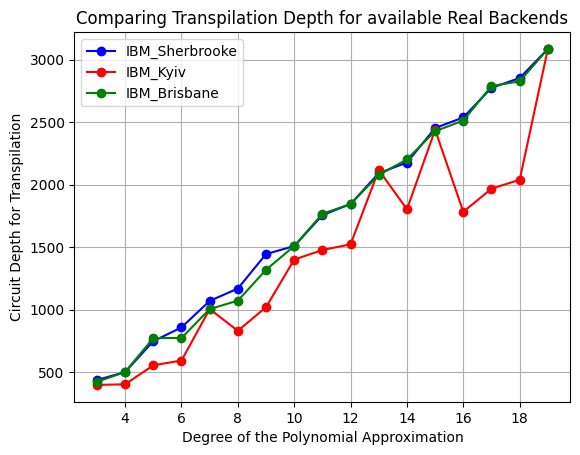

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(degrees,depth_autocallable_transpiled["ibm_sherbrooke"],"bo-",label="IBM_Sherbrooke")
plt.plot(degrees,depth_autocallable_transpiled["ibm_kyiv"],"ro-",label="IBM_Kyiv")
plt.plot(degrees,depth_autocallable_transpiled["ibm_brisbane"],"go-",label="IBM_Brisbane")
plt.legend()
plt.xlabel("Degree of the Polynomial Approximation")
plt.ylabel("Circuit Depth for Transpilation")
plt.title("Comparing Transpilation Depth of QSP for available Real Backends")
plt.grid(True)
plt.show()

In [45]:
depth_autocallable_transpiled

[746,
 746,
 746,
 746,
 746,
 746,
 746,
 746,
 746,
 414,
 496,
 746,
 823,
 1085,
 1160,
 1419]

In [40]:
d=8

 # Example normalized payoff values
decay_factor = 0.1  # Example decay factor for the payoff
payoff_values=payoff_function(0.01,1.2,1.8)
phi_angles=generate_phi(d)
# Generate the quantum circuit
qc_autocallable,qc_unitary = autocallable_contract_circuit(S, vol, r, T, N, d, phi_angles, payoff_values, decay_factor)

# Draw the circuit
isa_circ=pm.run(qc_autocallable)
isa_circ.depth()

C:\Users\Rajat\AppData\Local\Temp\ipykernel_13568\1939922867.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1-(K-np.exp(x**2*(2**p))*np.exp(-s)))


1160

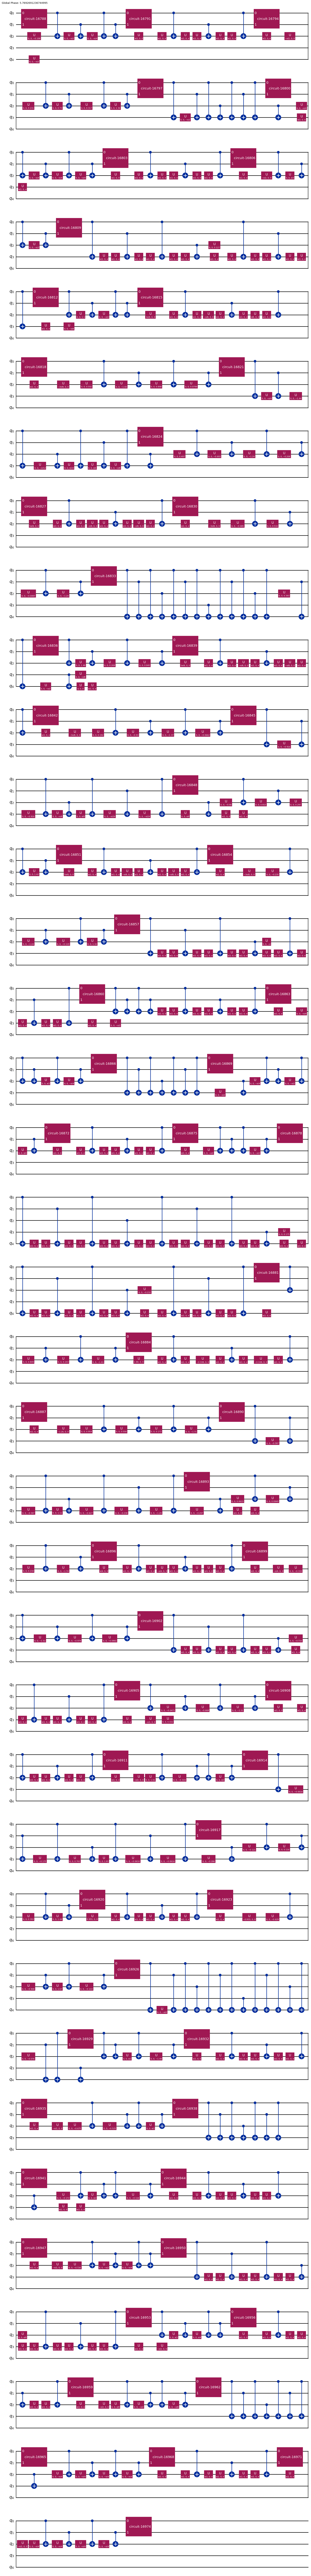

In [62]:
qc_unitary.draw("mpl")

qc_unitary.decompose().draw("mpl")

In [11]:
def payoff_function(x, K, r=0.05):
    return np.maximum(x - K, 0) * np.exp(-r)

def minimax_optimization(payoff_poly, n):
    def objective(phi):
        cheb_approx = np.cos(np.polyval(phi, np.linspace(-1, 1, 100)))
        return np.max(np.abs(cheb_approx - payoff_poly(np.linspace(-1, 1, 100))))
    
    initial_guess = np.random.uniform(-np.pi, np.pi, size=n)
    result = minimize(objective, initial_guess, method='BFGS')
    return result.x

In [12]:
def u_sin_matrix(payoff_with_decay, N):
    theta = np.arccos(np.clip(np.sqrt(payoff_with_decay), 0, 1))
    u_matrix = np.array([[np.cos(theta), np.sin(theta)], [np.sin(theta), -np.cos(theta)]])
    return np.kron(np.eye(2**(N-1)), u_matrix)

In [13]:
def autocallable_contract_circuit(S, vol, r, T, N, d, K, payoff_values, decay_factor):
    payoff_poly = lambda x: payoff_function(x, K, r) 
    phi_angles = minimax_optimization(payoff_poly, d)
    
    qc = QuantumCircuit(N + 1, 1)  
    qc.h(N)
    
    for i in range(d - 1):
        payoff_with_decay = payoff_values.mean() * np.exp(-decay_factor * i)
        U_sqrt_matrix = u_sin_matrix(payoff_with_decay, N)
        U_sqrt_gate = UnitaryGate(U_sqrt_matrix, label=f"$U_{{sin}}({i})$")
        
        qc.append(U_sqrt_gate, qargs=range(N))
        
        phi_d = phi_angles[i % len(phi_angles)]
        controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=f"$e^{{-i \\phi_{{{d-i}}} \\sigma_z}}$")
        qc.append(controlled_phase.control(N), qargs=list(range(N)) + [N])
        
        U_sqrt_inv_gate = UnitaryGate(U_sqrt_matrix.T.conj(), label=f"$U_{{sin}}^{{\\dag}}({i})$")
        qc.append(U_sqrt_inv_gate, qargs=range(N))
        qc.barrier()
    
        if d % 2 != 0:
        
          final_gate = UnitaryGate(U_sqrt_matrix, label=f"$U_{{\\text{{sin}}}}^{{({d-1})}}$")
          qc.append(final_gate, qargs=range(N))
        
          final_phi = phi_angles[d % len(phi_angles)]
          final_controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * final_phi)]]), label=f"$e^{{-i \\phi_{{0}} \\sigma_z}}$")
        
          qc.cx(N-1, N)
          qc.append(final_controlled_phase, qargs=[N])
          qc.cx(N-1, N)
    
    qc.h(N)
    qc.barrier()
    qc.measure(N, 0)
    
    return qc

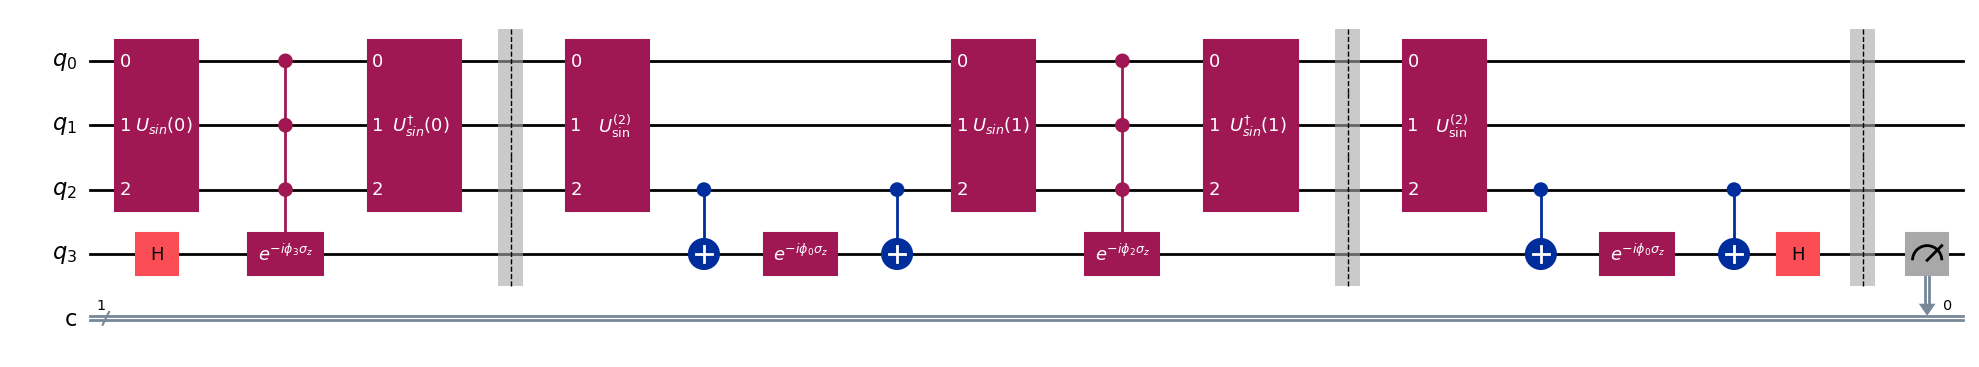

In [14]:
# Parameters for the circuit
S = 100
vol = 0.2
r = 0.05
T = 1
N = 3
d = 3
K = 95
payoff_values = np.array([100, 95, 90, 85])
decay_factor = 0.1

qc = autocallable_contract_circuit(S, vol, r, T, N, d, K, payoff_values, decay_factor)
qc.draw(output="mpl",fold=-1)

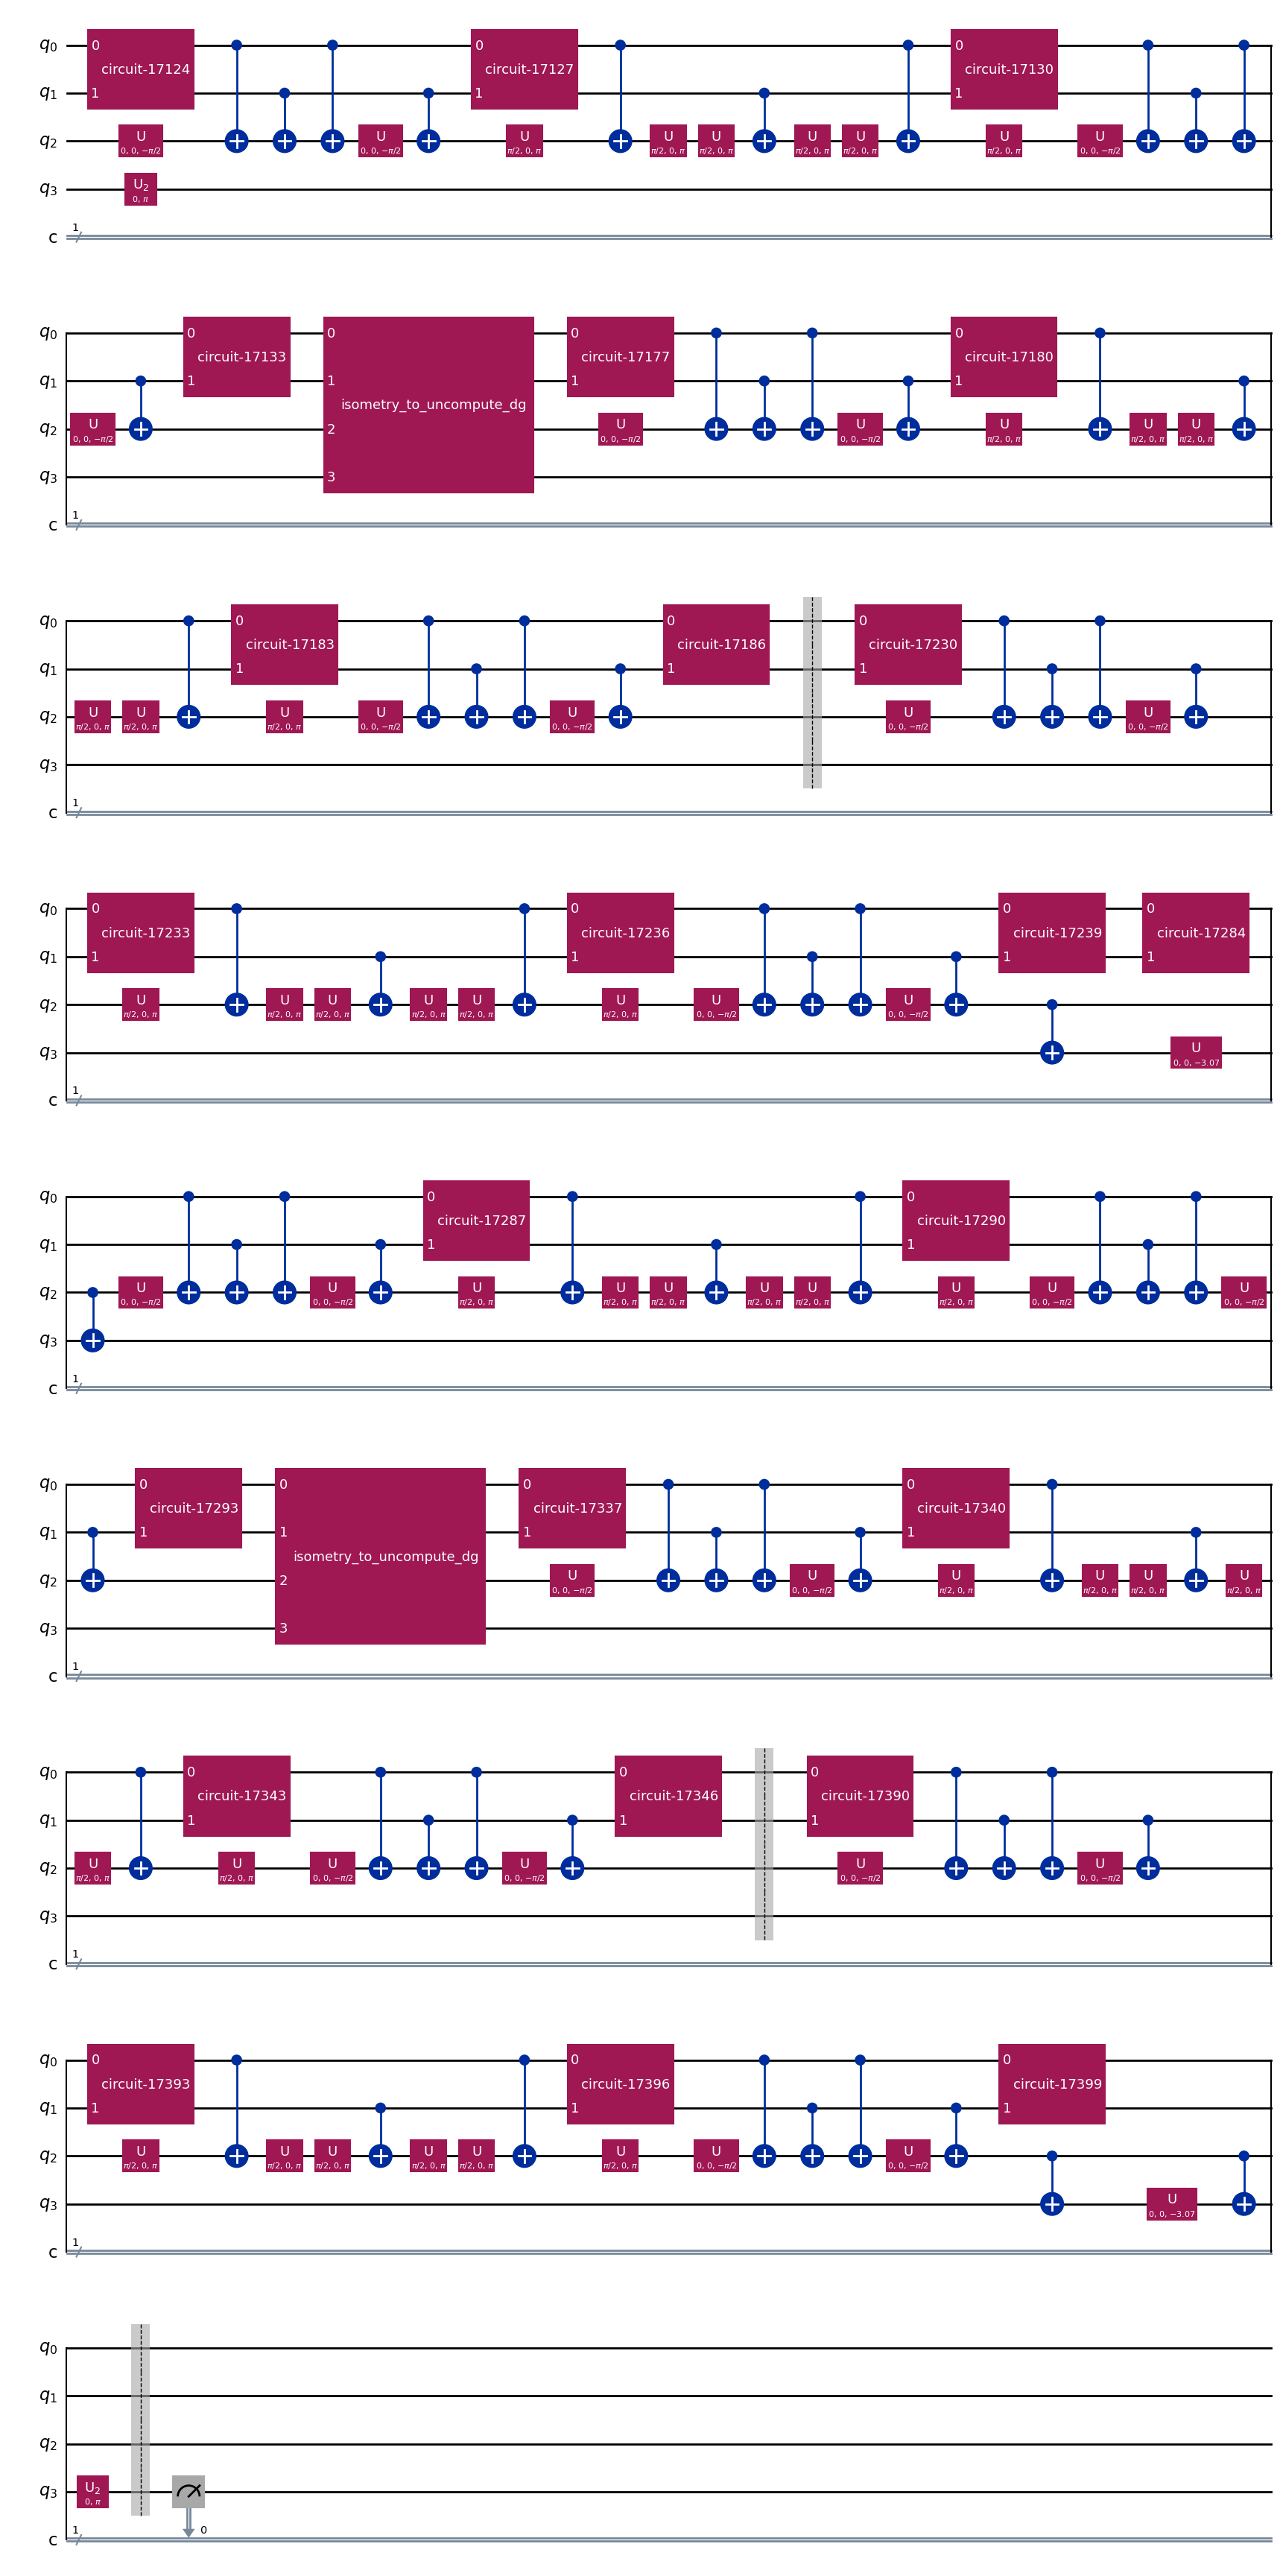

In [74]:
qc.decompose().draw(output="mpl")

In [89]:
from qiskit_aer import AerSimulator

pm=generate_preset_pass_manager(backend=AerSimulator(),optimization_level=3)

isa_circ=pm.run(qc)

print(isa_circ.depth())

64


In [90]:
backend=AerSimulator()

pubs=backend.run(isa_circ,shots=1024)
res=pubs.result()

counts=res.get_counts()

print(counts)

{'1': 735, '0': 289}


In [91]:
def compute_expected_payoff(counts, payoff_amount):
    successful_counts = 0
    total_counts = sum(counts.values())
    
    for outcome, freq in counts.items():
        if outcome[0] == '1':  # Assumes ancilla qubit is the first bit in outcome (indicating a "payoff" event)
            successful_counts += freq
    
    # Compute expected payoff: (successful frequency / total shots) * payoff amount
    expected_payoff = (successful_counts / total_counts) * payoff_amount
    return expected_payoff

In [92]:
from qiskit_aer import AerSimulator

In [93]:
counts = res.get_counts()
payoff_amount = payoff_values.mean()  # Mean of the possible payoff values for simplicity
expected_payoff = compute_expected_payoff(counts, payoff_amount)
print("Expected Payoff:", expected_payoff)

Expected Payoff: 66.39404296875


In [94]:
def payoff_function(x, K, r=0.05):
    return np.maximum(x - K, 0) * np.exp(-r)

def minimax_optimization(payoff_poly, n):
    def objective(phi):
        cheb_approx = np.cos(np.polyval(phi, np.linspace(-1, 1, 100)))
        return np.max(np.abs(cheb_approx - payoff_poly(np.linspace(-1, 1, 100))))
    
    initial_guess = np.random.uniform(-np.pi, np.pi, size=n)
    result = minimize(objective, initial_guess, method='BFGS')
    return result.x

def u_sin_matrix(payoff_with_decay, N):
    theta = np.arccos(np.clip(np.sqrt(payoff_with_decay), 0, 1))
    u_matrix = np.array([[np.cos(theta), np.sin(theta)], [np.sin(theta), -np.cos(theta)]])
    return np.kron(np.eye(2**(N-1)), u_matrix)

def autocallable_contract_circuit(S, vol, r, T, N, d, K, payoff_values, decay_factor):
    payoff_poly = lambda x: payoff_function(x, K, r) 
    phi_angles = minimax_optimization(payoff_poly, d)
    
    qc = QuantumCircuit(N + 1, 1)  
    qc.h(N)
    
    for i in range(d - 1):
        payoff_with_decay = payoff_values.mean() * np.exp(-decay_factor * i)
        U_sqrt_matrix = u_sin_matrix(payoff_with_decay, N)
        U_sqrt_gate = UnitaryGate(U_sqrt_matrix, label=f"$U_{{sin}}({i})$")
        
        qc.append(U_sqrt_gate, qargs=range(N))
        
        phi_d = phi_angles[i % len(phi_angles)]
        controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=f"$e^{{-i \\phi_{{{d-i}}} \\sigma_z}}$")
        qc.append(controlled_phase.control(N), qargs=list(range(N)) + [N])
        
        U_sqrt_inv_gate = UnitaryGate(U_sqrt_matrix.T.conj(), label=f"$U_{{sin}}^{{\\dag}}({i})$")
        qc.append(U_sqrt_inv_gate, qargs=range(N))
        qc.barrier()
    
        if d % 2 != 0:
          final_gate = UnitaryGate(U_sqrt_matrix, label=f"$U_{{\\text{{sin}}}}^{{({d-1})}}$")
          qc.append(final_gate, qargs=range(N))
        
          final_phi = phi_angles[d % len(phi_angles)]
          final_controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * final_phi)]]), label=f"$e^{{-i \\phi_{{0}} \\sigma_z}}$")
        
          qc.cx(N-1, N)
          qc.append(final_controlled_phase, qargs=[N])
          qc.cx(N-1, N)
    
    qc.h(N)
    qc.barrier()
    qc.measure(N, 0)
    
    return qc

def compute_expected_payoff(counts, K):
    total_shots = sum(counts.values())
    expected_payoff = sum((int(state[-1]) * (K)) for state, count in counts.items()) / total_shots
    return expected_payoff

def autocallable_payoff_for_d(S, vol, r, T, N, d, payoff_values, decay_factor):
    K = payoff_values.mean()
    phi_angles = minimax_optimization(lambda x: payoff_function(x, K, r), d)
    qc = autocallable_contract_circuit(S, vol, r, T, N, d, phi_angles, payoff_values, decay_factor)
    
    simulator = AerSimulator()
    transpiled_qc = qc
    circuit_depth = transpiled_qc.depth()
    
    result = simulator.run(transpiled_qc, shots=1024).result()
    counts = result.get_counts()
    
    expected_payoff = compute_expected_payoff(counts, K)
    return expected_payoff, circuit_depth

S = 100
vol = 0.2
r = 0.05
T = 1.0
N = 5
decay_factor = 0.1
payoff_values = np.array([80, 100, 120])

d_values = list(range(1, 16, 2))
payoffs = []
depths = []

for d in d_values:
    payoff, depth = autocallable_payoff_for_d(S, vol, r, T, N, d, payoff_values, decay_factor)
    payoffs.append(payoff)
    depths.append(depth)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Degree of Polynomial (d)')
ax1.set_ylabel('Expected Payoff', color=color)
ax1.plot(d_values, payoffs, color=color, marker='o', label='Expected Payoff')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Circuit Depth', color=color)
ax2.plot(d_values, depths, color=color, marker='x', linestyle='--', label='Circuit Depth')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Expected Payoff and Circuit Depth vs Degree of Polynomial (d)")
plt.show()

ValueError: operands could not be broadcast together with shapes (100,) (3,) 

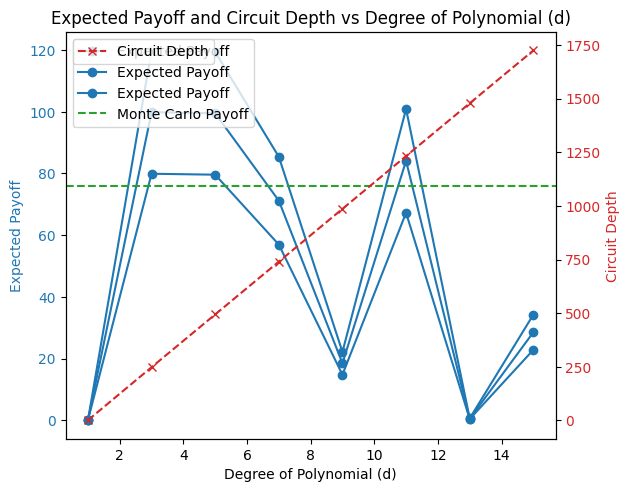

In [56]:
def payoff_function(x, K, r=0.05):
    return np.maximum(x - K, 0) * np.exp(-r)

def minimax_optimization(payoff_poly, n):
    def objective(phi):
        cheb_approx = np.cos(np.polyval(phi, np.linspace(-1, 1, 100)))
        return np.max(np.abs(cheb_approx - payoff_poly(np.linspace(-1, 1, 100))))
    
    initial_guess = np.random.uniform(-np.pi, np.pi, size=n)
    result = minimize(objective, initial_guess, method='BFGS')
    return result.x

def u_sin_matrix(payoff_with_decay, N):
    theta = np.arccos(np.clip(np.sqrt(payoff_with_decay), 0, 1))
    u_matrix = np.array([[np.cos(theta), np.sin(theta)], [np.sin(theta), -np.cos(theta)]])
    return np.kron(np.eye(2**(N-1)), u_matrix)

def autocallable_contract_circuit(S, vol, r, T, N, d, phi_angles, payoff_values, decay_factor):
    qc = QuantumCircuit(N + 1, 1)  
    qc.h(N)
    
    for i in range(d - 1):
        payoff_with_decay = payoff_values.mean() * np.exp(-decay_factor * i)
        U_sqrt_matrix = u_sin_matrix(payoff_with_decay, N)
        U_sqrt_gate = UnitaryGate(U_sqrt_matrix, label=f"$U_{{sin}}({i})$")
        
        qc.append(U_sqrt_gate, qargs=range(N))
        
        phi_d = phi_angles[i % len(phi_angles)]
        controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=f"$e^{{-i \\phi_{{{d-i}}} \\sigma_z}}$")
        qc.append(controlled_phase.control(N), qargs=list(range(N)) + [N])
        
        U_sqrt_inv_gate = UnitaryGate(U_sqrt_matrix.T.conj(), label=f"$U_{{sin}}^{{\\dag}}({i})$")
        qc.append(U_sqrt_inv_gate, qargs=range(N))
        qc.barrier()
    
        if d % 2 != 0:
          final_gate = UnitaryGate(U_sqrt_matrix, label=f"$U_{{\\text{{sin}}}}^{{({d-1})}}$")
          qc.append(final_gate, qargs=range(N))
        
          final_phi = phi_angles[d % len(phi_angles)]
          final_controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * final_phi)]]), label=f"$e^{{-i \\phi_{{0}} \\sigma_z}}$")
        
          qc.cx(N-1, N)
          qc.append(final_controlled_phase, qargs=[N])
          qc.cx(N-1, N)
    
    qc.h(N)
    qc.barrier()
    qc.measure(N, 0)
    
    return qc
'''
def compute_expected_payoff(counts, K):
    total_shots = sum(counts.values())
    expected_payoff = sum((int(state[-1]) * K) for state, count in counts.items()) / total_shots
    return expected_payoff
''' 
def compute_expected_payoff(counts, payoff_amount):
    successful_counts = 0
    total_counts = sum(counts.values())
    
    for outcome, freq in counts.items():
        if outcome[0] == '1':  # Assumes ancilla qubit is the first bit in outcome (indicating a "payoff" event)
            successful_counts += freq
    
    # Compute expected payoff: (successful frequency / total shots) * payoff amount
    expected_payoff = (successful_counts / total_counts) * payoff_amount
    return expected_payoff

def autocallable_payoff_for_d(S, vol, r, T, N, d, payoff_values, decay_factor):
    K = payoff_values.mean()
    phi_angles = minimax_optimization(lambda x: payoff_function(x, K, r), d)
    qc = autocallable_contract_circuit(S, vol, r, T, N, d, phi_angles, payoff_values, decay_factor)
    
    simulator = AerSimulator()
    transpiled_qc = pm.run(qc)
    circuit_depth = transpiled_qc.depth()
    
    result = simulator.run(transpiled_qc, shots=1024).result()
    counts = result.get_counts()
    
    expected_payoff = compute_expected_payoff(counts, payoff_values)
    return expected_payoff, circuit_depth

S = 100
vol = 0.2
r = 0.05
T = 1.0
N = 5
decay_factor = 0.1
payoff_values = np.array([80, 100, 120])

d_values = list(range(1, 16, 2))
payoffs = []
depths = []

for d in d_values:
    payoff, depth = autocallable_payoff_for_d(S, vol, r, T, N, d, payoff_values, decay_factor)
    payoffs.append(payoff)
    depths.append(depth)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Degree of Polynomial (d)')
ax1.set_ylabel('Expected Payoff', color=color)
ax1.plot(d_values, payoffs, color=color, marker='o', label='Expected Payoff')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(76.10, color='tab:green', linestyle='--', label='Monte Carlo Payoff')
ax1.legend(loc='upper left')


ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Circuit Depth', color=color)
ax2.plot(d_values, depths, color=color, marker='x', linestyle='--', label='Circuit Depth')
ax2.tick_params(axis='y', labelcolor=color)


plt.legend()
fig.tight_layout()
plt.title("Expected Payoff and Circuit Depth vs Degree of Polynomial (d)")
plt.show()

In [95]:
S = 100         # Initial spot price
vol = 0.2       # Volatility
r = 0.05        # Risk-free rate
T = 1.0         # Time to maturity
N = 5           # Number of observations
payoff_values = np.array([80, 100, 120])  # Thresholds for autocallable payoff
decay_factor = 0.1  # Decay factor

# Monte Carlo settings
num_simulations = 10000  # Number of Monte Carlo simulations
dt = T / N  # Time increment per observation

# Function to simulate Geometric Brownian Motion
def simulate_gbm_path(S, r, vol, T, N):
    dt = T / N
    path = [S]
    for _ in range(1, N+1):
        S *= np.exp((r - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * np.random.normal())
        path.append(S)
    return np.array(path)

# Run Monte Carlo simulations
payoffs = []
for _ in range(num_simulations):
    path = simulate_gbm_path(S, r, vol, T, N)
    payoff = 0
    for i in range(N):
        if path[i] >= payoff_values[i % len(payoff_values)]:  # Check against threshold
            payoff = payoff_values[i % len(payoff_values)] * np.exp(-decay_factor * i)  # Discounted payoff
            break
    payoffs.append(payoff * np.exp(-r * T))  # Apply risk-free discounting

# Calculate the expected payoff
expected_payoff_mc = np.mean(payoffs)
print(f"Monte Carlo Expected Payoff: {expected_payoff_mc:.2f}")

Monte Carlo Expected Payoff: 76.10


In [96]:
pm=generate_preset_pass_manager(backend=AerSimulator(),optimization_level=3)

In [97]:


# Monte Carlo function
def monte_carlo_payoff(S, vol, r, T, N, payoff_values, decay_factor, num_simulations=10000):
    dt = T / N
    payoffs = []
    for _ in range(num_simulations):
        S_t = S
        for i in range(N):
            S_t *= np.exp((r - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * np.random.normal())
            if S_t >= payoff_values[i % len(payoff_values)]:
                payoff = payoff_values[i % len(payoff_values)] * np.exp(-decay_factor * i)
                break
        else:
            payoff = 0
        payoffs.append(payoff * np.exp(-r * T))
    return np.mean(payoffs)

# Parameters
S = 100
vol = 0.2
r = 0.05
T = 1.0
N = 5
decay_factor = 0.1
payoff_values = np.array([80, 100, 120])

# Monte Carlo expected payoff
expected_payoff_mc = monte_carlo_payoff(S, vol, r, T, N, payoff_values, decay_factor)

# Quantum approach for polynomial degrees
d_values = list(range(2,10, 2))
payoffs = []
depths = []

for d in d_values:
    payoff, depth = autocallable_payoff_for_d(S, vol, r, T, N, d, payoff_values, decay_factor)
    payoffs.append(payoff.mean())
    depths.append(depth)



# Plotting payoff and circuit depth vs d
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Degree of Polynomial (d)')
ax1.set_ylabel('Expected Payoff', color=color)
ax1.plot(d_values, payoffs, color=color, marker='o', label='QSP Expected Payoff')
ax1.tick_params(axis='y', labelcolor=color)

# Add the Monte Carlo payoff as a horizontal line
ax1.axhline(expected_payoff_mc, color='tab:green', linestyle='--', label='Monte Carlo Payoff')
ax1.legend(loc='upper left')

# Instantiate a second y-axis for circuit depth
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Circuit Depth', color=color)
ax2.plot(d_values, depths, color=color, marker='x', linestyle='--', label='Circuit Depth')
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(d_values)
fig.tight_layout()
plt.title("Expected Payoff and Circuit Depth vs Degree of Polynomial (d)")
plt.show()


ValueError: operands could not be broadcast together with shapes (100,) (2,) 

In [127]:
payoffs

[array([0., 0., 0.]),
 array([57.1875  , 71.484375, 85.78125 ]),
 array([0., 0., 0.]),
 array([6.5625  , 8.203125, 9.84375 ]),
 array([63.828125  , 79.78515625, 95.7421875 ]),
 array([36.328125  , 45.41015625, 54.4921875 ]),
 array([ 8.203125  , 10.25390625, 12.3046875 ]),
 array([ 76.484375  ,  95.60546875, 114.7265625 ])]

In [3]:
from fable import fable
from qiskit import QuantumCircuit 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator


In [19]:
matrix=np.array([[1,0],[0,1]],dtype=float)
print(matrix)

[[1. 0.]
 [0. 1.]]


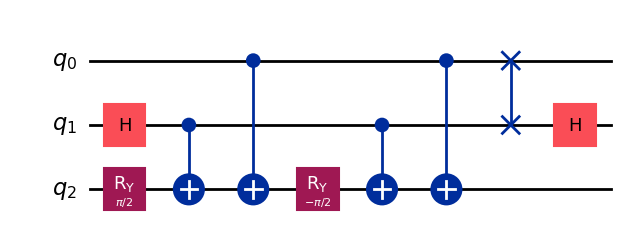

In [20]:
circ,alpha=fable(matrix)
circ.draw(output="mpl")

In [21]:
from qiskit.circuit.library import UnitaryGate

[[1.   0.25]
 [0.25 0.4 ]]


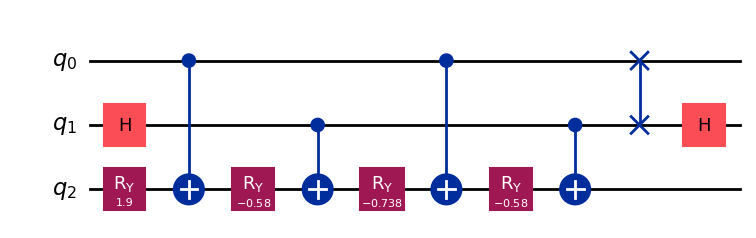

In [45]:
custom_mat=np.array([[1,0.25],[0.25,0.4]])
print(custom_mat)

circ_custom,alpha=fable(custom_mat)
circ_custom.draw(output="mpl")

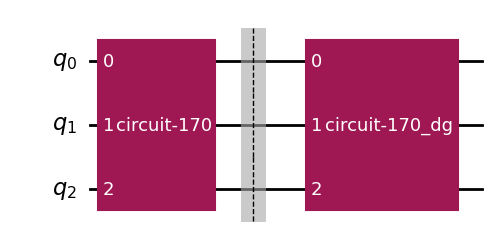

In [37]:
qc=QuantumCircuit(3)
qc.append(circ,qargs=range(3))
qc.barrier()
qc.append(circ.inverse(),qargs=range(3))
qc.draw(output="mpl")

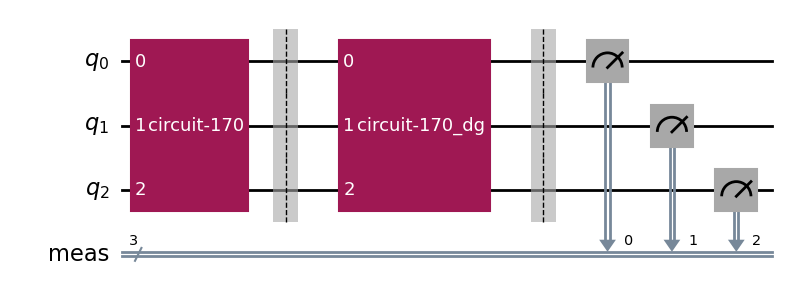

In [38]:
qc.measure_all()
qc.draw(output="mpl")

In [41]:
simulator=AerSimulator()
pm=generate_preset_pass_manager(backend=simulator,optimization_level=3)

isa_circ=pm.run(qc)
print(isa_circ.depth())

15


In [43]:
pubs=simulator.run(isa_circ)
res=pubs.result()

res.get_counts()

{'000': 1024}

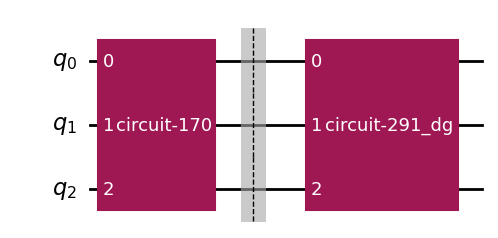

In [54]:
qc=QuantumCircuit(3)
qc.append(circ,qargs=range(3))
qc.barrier()
qc.append(circ_custom.inverse(),qargs=range(3))
qc.draw(output="mpl")

In [55]:
simulator=AerSimulator()
pm=generate_preset_pass_manager(backend=simulator,optimization_level=3)


qc.measure_all()


isa_circ=pm.run(qc)
print(isa_circ.depth())


16


In [56]:
pubs=simulator.run(isa_circ)
res=pubs.result()

res.get_counts()

{'000': 983, '100': 15, '110': 26}